In [1]:
import funs
import funs.model as model

import torch
import os

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import transforms

import pandas as pd 
import numpy as np  

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config = funs.load_yaml('./config.yaml')

funs.set_seed(config.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

device = cuda


In [3]:
data_root_dirs = os.path.join(config.dataset_root)

Cylindrical_dirs = funs.get_bearing_paths(data_root_dirs, 'CylindricalRoller', config.rpm)
DepGroove_dirs = funs.get_bearing_paths(data_root_dirs, 'DeepGrooveBall', config.rpm)
Tapered_dirs = funs.get_bearing_paths(data_root_dirs, 'TaperedRoller', config.rpm)

In [4]:
print("Making dataframes...")

Cylindrical_df = funs.make_dataframe(config, Cylindrical_dirs)
DepGroove_df =funs.make_dataframe(config, DepGroove_dirs)
Tapered_df = funs.make_dataframe(config, Tapered_dirs)

Making dataframes...


In [5]:
print("concat dataframes...")

all_df = pd.concat([Cylindrical_df, DepGroove_df, Tapered_df], ignore_index=True)

concat dataframes...


In [6]:
train_df, val_df, test_df = funs.split_dataframe(all_df, 0.6, 0.2)

train_data, train_label = funs.build_from_dataframe(train_df, config.sample_size, config.overlap, False)
val_data, val_label = funs.build_from_dataframe(val_df, config.sample_size, config.overlap, False)
test_data, test_label = funs.build_from_dataframe(test_df, config.sample_size, config.overlap, False)

In [7]:
# np -> tensor transform
tf_data = transforms.Compose([funs.processing.NpToTensor(), funs.processing.ToSignal()])
tf_label = transforms.Compose([funs.processing.NpToTensor()])

In [8]:
train_dataset = funs.NumpyDataset(train_data, train_label, transform=tf_data, target_transform=tf_label)
val_dataset = funs.NumpyDataset(val_data, val_label, transform=tf_data, target_transform=tf_label)
test_dataset = funs.NumpyDataset(test_data, test_label, transform=tf_data, target_transform=tf_label)

train_loader = funs.get_dataloader(train_dataset, config.batch_size, True)
val_loader = funs.get_dataloader(val_dataset, config.batch_size, False)
test_loader = funs.get_dataloader(test_dataset, config.batch_size, False)

In [9]:
n_classes = all_df["label"].max() - all_df["label"].min() + 1
model = model.Mynet2(n_classes=n_classes).to(device)

In [10]:
optimizer = Adam(model.parameters(), lr = float(config.learning_rate))
loss = CrossEntropyLoss()

In [11]:
model_name = 'FRFconv-TDS'

trainer = funs.Trainer(model, loss, optimizer, device, train_loader, val_loader)
# train_loss, val_loss = trainer.train(config.epoch)
# trainer.save(config.model_root, model_name)

model_path = f'{config.model_root}/{model_name}.pt'
trainer.model.load_state_dict(torch.load(model_path, weights_only=True))

fault_label_list, val_loss, predicted_label_list = trainer.eval() 


Starting Evaluation... 
----------------------------------------
Validation Loss: 0.32091


Class-wise Accuracy:
Class 0: 0.92272
Class 1: 0.88463
Class 2: 0.79391
Class 3: 0.95878
Class 4: 0.95945
Class 5: 0.91913
Class 6: 0.78427
Class 7: 0.85282
Class-wise accuracy logged to log_per_acc.txt


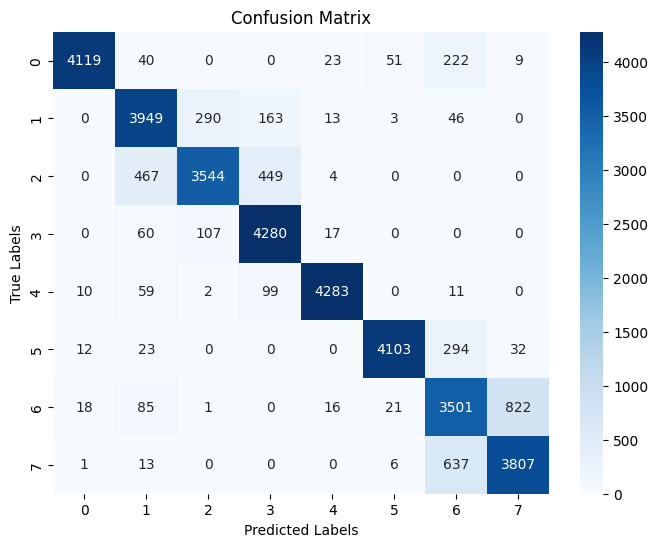

In [12]:
# acc per class logging
log_file = 'log_per_acc.txt'
funs.log_class_acc(config.log_root, fault_label_list, predicted_label_list, f'{log_file}')

# confusion matrix plot
funs.plot_confusion_matrix(config.pic_root ,fault_label_list, predicted_label_list, 'confusion_matrix.png')